In [ ]:
import os
from pathlib import Path

# ===== CONFIGURATION: choose thickness folder and specific .emd =====
DATASET_FOLDER = "120nm"            # Options: "60nm", "30nm", "120nm"
INPUT_FILENAME = None               # e.g., "1508 20250613 105 kx Ceta Camera" or full name with .emd
# ====================================================================

# Define base paths
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "data" / DATASET_FOLDER
PROCESSED_DIR = BASE_DIR / "processed" / DATASET_FOLDER
ANNOTATIONS_DIR = BASE_DIR / "annotations" / DATASET_FOLDER

# Find candidate .emd files
emd_files = list(DATA_DIR.glob("*.emd"))
if not emd_files:
    raise FileNotFoundError(f"No .emd file found in {DATA_DIR}")

# Select specific file if requested
if INPUT_FILENAME:
    candidates = [f for f in emd_files if f.name == INPUT_FILENAME or f.stem == INPUT_FILENAME]
    if not candidates:
        available = "\n  - ".join(f.name for f in emd_files)
        raise FileNotFoundError(
            "Requested INPUT_FILENAME not found. Available files:\n  - " + available
        )
    INPUT_FILE = candidates[0]
else:
    if len(emd_files) > 1:
        available = "\n  - ".join(f.name for f in emd_files)
        raise FileExistsError(
            "Multiple .emd files found; set INPUT_FILENAME to choose one:\n  - " + available
        )
    INPUT_FILE = emd_files[0]

BASE_FILENAME = INPUT_FILE.stem  # Filename without extension

# Define output paths using the same base filename
OUTPUT_NPY = PROCESSED_DIR / f"{BASE_FILENAME}.npy"
OUTPUT_VIDEO = PROCESSED_DIR / f"{BASE_FILENAME}.mp4"

# Display configuration
print(f"{'='*60}")
print("Dataset Configuration")
print(f"{'='*60}")
print(f"Folder:       {DATASET_FOLDER}")
print(f"Input file:   {INPUT_FILE.name}")
print(f"Base name:    {BASE_FILENAME}")
print(f"{'='*60}")
print(f"Output .npy:  {OUTPUT_NPY}")
print(f"Output video: {OUTPUT_VIDEO}")
print(f"{'='*60}")

Dataset Configuration
Folder:       120nm
Input file:   20240715 2022 Camera 66000 x.emd
Base name:    20240715 2022 Camera 66000 x
Output .npy:  processed\120nm\20240715 2022 Camera 66000 x.npy
Output video: processed\120nm\20240715 2022 Camera 66000 x.mp4


# Noise Removal and Frame Registration Pipeline

This notebook processes in-situ tensile test data by:
1. Removing low-quality frames based on sharpness and edge content
2. Registering frames to correct drift using phase cross-correlation
3. Saving processed data for annotation and training

In [4]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift as scipy_shift

# Load the EMD file using the configured path
print(f"Loading: {INPUT_FILE}")
s = hs.load(str(INPUT_FILE))

# Check the signal structure
print(s)
print(f"Signal shape: {s.data.shape}")
print(f"Signal axes: {s.axes_manager}")

Loading: data\120nm\20240715 2022 Camera 66000 x.emd
<Signal2D, title: Ceta, dimensions: (525|1024, 1024)>
Signal shape: (525, 1024, 1024)
Signal axes: <Axes manager, axes: (525|1024, 1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
            Time |    525 |      0 |       0 |     1.2 |      s 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |   1024 |      0 | -3.2e+02 |    0.63 |     nm 
               y |   1024 |      0 | -3.2e+02 |    0.63 |     nm 


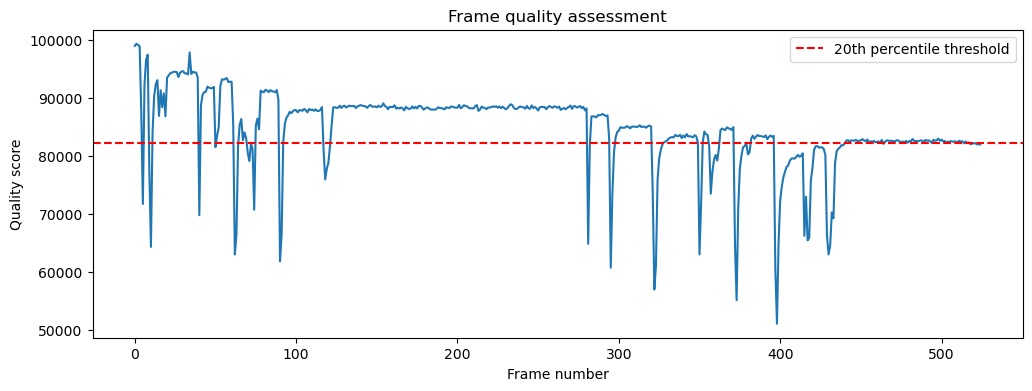

Keeping 420/525 frames


In [5]:
def assess_frame_quality(signal):
    """
    Calculate quality metrics for each frame in the stack
    Returns array of quality scores
    """
    n_frames = signal.data.shape[0]
    quality_scores = np.zeros(n_frames)
    
    for i in range(n_frames):
        frame = signal.inav[i].data
        
        # Method 1: Variance of Laplacian (sharpness)
        from scipy.ndimage import laplace
        laplacian = laplace(frame)
        sharpness = np.var(laplacian)
        
        # Method 2: Standard deviation (contrast)
        contrast = np.std(frame)
        
        # Method 3: Edge content
        from scipy.ndimage import sobel
        edges_x = sobel(frame, axis=0)
        edges_y = sobel(frame, axis=1)
        edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)
        edge_content = np.mean(edge_magnitude)
        
        # Combined quality score
        quality_scores[i] = sharpness * edge_content
    
    return quality_scores

# Assess quality
quality = assess_frame_quality(s)

# Visualize quality over time
plt.figure(figsize=(12, 4))
plt.plot(quality)
plt.xlabel('Frame number')
plt.ylabel('Quality score')
plt.title('Frame quality assessment')
plt.axhline(np.percentile(quality, 20), color='r', linestyle='--', 
            label='20th percentile threshold')
plt.legend()
plt.show()

# Identify good frames
threshold = np.percentile(quality, 20)  # Remove bottom 20%
good_frame_indices = np.where(quality > threshold)[0]
print(f"Keeping {len(good_frame_indices)}/{len(quality)} frames")

In [6]:
def remove_bad_frames(signal, good_indices):
    """
    Create new signal with only good frames
    """
    # Extract good frames
    good_data = signal.data[good_indices]
    
    # Create new signal
    s_clean = hs.signals.Signal2D(good_data)
    
    # Copy metadata and calibration
    s_clean.axes_manager[0].name = signal.axes_manager[0].name
    s_clean.axes_manager[0].units = signal.axes_manager[0].units
    s_clean.axes_manager[1].scale = signal.axes_manager[1].scale
    s_clean.axes_manager[1].units = signal.axes_manager[1].units
    s_clean.axes_manager[2].scale = signal.axes_manager[2].scale
    s_clean.axes_manager[2].units = signal.axes_manager[2].units
    
    return s_clean

# Remove bad frames
s_clean = remove_bad_frames(s, good_frame_indices)

In [7]:
def register_signal_stack(signal, reference_frame=0, upsample_factor=10):
    """
    Register all frames to a reference frame using phase cross-correlation
    
    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    reference_frame : int
        Index of frame to use as reference (default: 0)
    upsample_factor : int
        Subpixel precision (higher = more precise but slower)
    
    Returns:
    --------
    registered_signal : hyperspy Signal2D
        Registered signal stack
    shifts : ndarray
        Array of (y, x) shifts for each frame
    """
    from tqdm.notebook import tqdm  # For Jupyter notebooks
    # from tqdm import tqdm  # For terminal/scripts
    
    n_frames = signal.data.shape[0]
    reference = signal.inav[reference_frame].data
    
    registered_data = np.zeros_like(signal.data)
    shifts = np.zeros((n_frames, 2))
    
    # Use tqdm for progress bar with more details
    for i in tqdm(range(n_frames), 
                  desc="Registering frames", 
                  unit="frame",
                  colour='green',
                  leave=True):
        
        frame = signal.inav[i].data
        
        # Calculate shift using phase cross-correlation
        shift, error, diffphase = phase_cross_correlation(
            reference, 
            frame, 
            upsample_factor=upsample_factor
        )
        
        shifts[i] = shift
        
        # Apply shift
        registered_data[i] = scipy_shift(frame, shift, mode='constant', cval=0)
    
    # Create registered signal
    s_registered = hs.signals.Signal2D(registered_data)
    
    # Copy metadata
    s_registered.axes_manager[0].name = signal.axes_manager[0].name
    s_registered.axes_manager[0].units = signal.axes_manager[0].units
    s_registered.axes_manager[1].scale = signal.axes_manager[1].scale
    s_registered.axes_manager[1].units = signal.axes_manager[1].units
    s_registered.axes_manager[2].scale = signal.axes_manager[2].scale
    s_registered.axes_manager[2].units = signal.axes_manager[2].units
    
    print(f"\nRegistration complete! Processed {n_frames} frames.")
    print(f"Maximum shift: ({np.max(np.abs(shifts[:,0])):.2f}, {np.max(np.abs(shifts[:,1])):.2f}) pixels")
    
    return s_registered, shifts

# Register cleaned signal
s_registered, shifts = register_signal_stack(s_clean, reference_frame=0, upsample_factor=10)

Registering frames:   0%|          | 0/420 [00:00<?, ?frame/s]


Registration complete! Processed 420 frames.
Maximum shift: (164.90, 95.80) pixels


In [ ]:
def interactive_quality_check(signal, quality_scores):
    """
    Interactive tool to check quality assessment
    """
    import ipywidgets as widgets
    from IPython.display import display
    
    def show_frame(frame_idx):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Show frame
        axes[0].imshow(signal.inav[frame_idx].data, cmap='gray')
        axes[0].set_title(f'Frame {frame_idx}')
        axes[0].axis('off')
        
        # Show quality scores
        axes[1].plot(quality_scores)
        axes[1].axvline(frame_idx, color='r', linestyle='--')
        axes[1].scatter([frame_idx], [quality_scores[frame_idx]], 
                       color='r', s=100, zorder=5)
        axes[1].set_xlabel('Frame number')
        axes[1].set_ylabel('Quality score')
        axes[1].set_title(f'Quality: {quality_scores[frame_idx]:.2f}')
        
        plt.tight_layout()
        plt.show()
    
    slider = widgets.IntSlider(
        min=0, 
        max=len(signal.data)-1, 
        step=1, 
        value=0,
        description='Frame:'
    )
    
    widgets.interact(show_frame, frame_idx=slider)

# Use in Jupyter notebook
interactive_quality_check(s_registered, quality)

interactive(children=(IntSlider(value=0, description='Frame:', max=419), Output()), _dom_classes=('widget-inte…

In [9]:
import cv2
from tqdm.notebook import tqdm

def save_signal_as_video(signal, filename='registered_frames.mp4', fps=25, codec='mp4v', 
                         frame_skip=1, max_frames=None, chunk_size=100, 
                         vmin_percentile=1, vmax_percentile=99):
    """
    Save hyperspy signal stack as video file with memory-efficient processing
    
    Parameters:
    -----------
    signal : hyperspy Signal2D
        Input signal stack
    filename : str
        Output filename (with .mp4 or .avi extension)
    fps : int
        Frames per second for output video
    codec : str
        Video codec ('mp4v' for mp4, 'XVID' for avi)
    frame_skip : int
        Use every Nth frame (1=all frames, 2=every other frame, etc.)
        Useful for large datasets to reduce output size
    max_frames : int or None
        Maximum number of frames to include (after skipping). None = all frames
    chunk_size : int
        Number of frames to normalize at once (reduces memory usage)
    vmin_percentile : float
        Lower percentile for contrast stretching (default: 1)
    vmax_percentile : float
        Upper percentile for contrast stretching (default: 99)
    """
    n_frames = signal.data.shape[0]
    height, width = signal.data.shape[1], signal.data.shape[2]
    
    # Calculate which frames to include
    frame_indices = np.arange(0, n_frames, frame_skip)
    if max_frames is not None:
        frame_indices = frame_indices[:max_frames]
    
    total_output_frames = len(frame_indices)
    
    print(f"Input: {n_frames} frames")
    print(f"Output: {total_output_frames} frames (skip={frame_skip}, max={max_frames})")
    print(f"Resolution: {width}x{height}, FPS: {fps}")
    print(f"Estimated video duration: {total_output_frames/fps:.1f} seconds")
    
    # Calculate percentile-based intensity range for better contrast (chunked)
    print(f"\nCalculating intensity range (percentiles: {vmin_percentile}-{vmax_percentile})...")
    all_samples = []
    sample_size = min(50000, width * height * 5)  # Sample ~5 frames worth of pixels
    
    for i in tqdm(range(0, len(frame_indices), max(1, len(frame_indices)//10)), 
                  desc="Sampling", unit="frame"):
        idx = frame_indices[i]
        frame_sample = signal.data[idx].flatten()
        # Take random sample from this frame
        sample_idx = np.random.choice(len(frame_sample), 
                                     min(len(frame_sample), sample_size//10), 
                                     replace=False)
        all_samples.extend(frame_sample[sample_idx])
    
    # Calculate percentiles from samples
    data_min = np.percentile(all_samples, vmin_percentile)
    data_max = np.percentile(all_samples, vmax_percentile)
    
    print(f"Intensity range: [{data_min:.2f}, {data_max:.2f}]")
    print(f"  (This clips ~{vmin_percentile}% darkest and ~{100-vmax_percentile}% brightest pixels)")
    
    # Define codec and create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height), isColor=False)
    
    if not out.isOpened():
        print(f"Error: Could not open video writer for {filename}")
        print("Try: codec='XVID' and filename='output.avi' as alternative")
        return False
    
    # Write frames in chunks (memory efficient)
    print("\nWriting video...")
    for i in tqdm(range(0, len(frame_indices), chunk_size), desc="Encoding", unit="chunk"):
        chunk_idx = frame_indices[i:i+chunk_size]
        
        # Normalize chunk with percentile clipping
        chunk_data = signal.data[chunk_idx].copy()
        # Clip values outside the range
        chunk_data = np.clip(chunk_data, data_min, data_max)
        # Normalize to 0-255
        chunk_normalized = ((chunk_data - data_min) / (data_max - data_min) * 255).astype(np.uint8)
        
        # Write each frame in chunk
        for frame in chunk_normalized:
            out.write(frame)
    
    out.release()
    print(f"\n✓ Video saved: {filename}")
    print(f"  Frames: {total_output_frames}, Resolution: {width}x{height}, FPS: {fps}")
    
    return True

# Save video using the configured output path
save_signal_as_video(s_registered, filename=str(OUTPUT_VIDEO), fps=25, codec='mp4v')

# Alternative: Adjust contrast range if needed (e.g., for very noisy data)
# save_signal_as_video(s_registered, filename=str(OUTPUT_VIDEO), fps=25, 
#                      codec='mp4v', vmin_percentile=2, vmax_percentile=98)

Input: 420 frames
Output: 420 frames (skip=1, max=None)
Resolution: 1024x1024, FPS: 25
Estimated video duration: 16.8 seconds

Calculating intensity range (percentiles: 1-99)...


Sampling:   0%|          | 0/10 [00:00<?, ?frame/s]

Intensity range: [0.00, 329.17]
  (This clips ~1% darkest and ~1% brightest pixels)

Writing video...


Encoding:   0%|          | 0/5 [00:00<?, ?chunk/s]


✓ Video saved: processed\120nm\20240715 2022 Camera 66000 x.mp4
  Frames: 420, Resolution: 1024x1024, FPS: 25


True

In [10]:
# Save the processed data using the configured path
print(f"Saving registered frames...")
np.save(str(OUTPUT_NPY), s_registered.data)
print(f"✓ Saved to: {OUTPUT_NPY}")
print(f"  Shape: {s_registered.data.shape}")
print(f"  File size: {OUTPUT_NPY.stat().st_size / (1024**2):.1f} MB")

Saving registered frames...
✓ Saved to: processed\120nm\20240715 2022 Camera 66000 x.npy
  Shape: (420, 1024, 1024)
  File size: 3360.0 MB
